In [ ]:
!pip install datasets

In [1]:
import torch
import re
import torch.nn.functional as F
import re
import numpy as np
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/angel/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [29]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        #self.output_layer = nn.Linear(embedding_size, vocab_size)

    def forward(self, center, context):
        #embeddings = self.embedding(x)
        #output = self.output_layer(embeddings)

        return self.embedding(center), self.embedding(context)

In [3]:
from datasets import load_dataset

class WordsDataset(torch.utils.data.Dataset):
    
    def __init__(self, context_window, k):
        self.dataset = load_dataset('large_spanish_corpus', name='all_wikis', split='train')[:100000]
        self.tokenizer = get_tokenizer('basic_english')

        self.count_words()

        self.vocab = build_vocab_from_iterator(map(self.tokenizer, self.dataset['text']), specials=['<unk>'], min_freq=1, max_tokens=90000)
        self.vocab.set_default_index(self.vocab["<unk>"])

        self.context_window = context_window
        self.k = k
        self.temperature = 10e-5

        print(f'Len of vocab {len(self.vocab)}')

        self.build_dataset()

    def count_words(self):
        self.freq = {}
        for document in self.dataset['text']:
            document = re.sub('[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ]+', ' ', document)
            tokens = self.tokenizer(document)
    
            for word in tokens:
                if word in self.freq:
                    self.freq[word] += 1
                else:
                    self.freq[word] = 1

        self.total= sum(self.freq.values())

    def build_dataset(self):
        self.X = []
        self.y = []

        for document in self.dataset['text']:
          document = re.sub('[^A-Za-z0-9áéíóúñÁÉÍÓÚÑ]+', ' ', document)
          tokens = self.tokenizer(document)

          for i, word in enumerate(tokens):
              center = word

              if i < self.context_window:
                  continue
              elif i > len(tokens) - self.context_window - 1:
                  continue
              else:
                  context = tokens[i - self.context_window:i] + tokens[i + 1:i + self.context_window + 1]

              for word in context:
                subsample_probability = 1 - np.sqrt(self.temperature / (self.freq[center] / self.total))

                if np.random.rand() < subsample_probability:
                    continue

                if self.vocab[center] == self.vocab["<unk>"] or self.vocab[word] == self.vocab["<unk>"]:
                    continue

                self.X.append(self.vocab([center]))
                self.y.append(self.vocab([word]))

                if len(self.X) % 1000000 == 0:
                    print(f'Center: {center} - Context: {word}')

        self.X = torch.tensor(self.X).long()
        self.y = torch.tensor(self.y).squeeze().long()

        print(self.X.shape)
        print(self.y.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
embedding_size = 300
context_window = 5
batch_size = 1024
k = 5

In [6]:
from torch.utils.data import DataLoader

word_dataset = WordsDataset(context_window, k)
dataloader = DataLoader(word_dataset, batch_size=batch_size, shuffle=True)

print(f'Number of samples: {len(word_dataset.dataset["text"])}')

Found cached dataset large_spanish_corpus (/home/angel/.cache/huggingface/datasets/large_spanish_corpus/all_wikis/1.1.0/866aa19decb2ee81eed3e918e7150937330cc993815e36beda5f40a992058639)


Len of vocab 89826
Center: encargarse - Context: la
Center: cultural - Context: ejemplo
Center: presencia - Context: la
Center: vigas - Context: caso
torch.Size([4642920, 1])
torch.Size([4642920])
Number of samples: 100000


In [7]:
model = SkipGram(len(word_dataset.vocab), embedding_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [30]:
for batch, (X, y) in enumerate(dataloader):
    X = X.squeeze().to(device)
    y = F.one_hot(y, num_classes=len(word_dataset.vocab)).float().to(device)

    print(X.shape)
    print(y.shape)

    break

torch.Size([1024])
torch.Size([1024, 89826])


In [26]:
pred = model(X)

negative_samples = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(pred[:, y.argmax(1)])))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(pred[:, negative_samples]))))

loss

tensor(23.0507, device='cuda:0', grad_fn=<SubBackward0>)

In [9]:
y_labels = y.argmax(1)

for i in range(X.shape[0]):
    center = word_dataset.vocab.lookup_token(X[i].item())
    context =  word_dataset.vocab.lookup_token(y_labels[i].item())

    print(f'Center: {center} - Context: {context}')


Center: mide - Context: el
Center: paciente - Context: encuentra
Center: cabo - Context: voluntarios
Center: tal - Context: no
Center: control - Context: y
Center: duda - Context: aunque
Center: superiormente - Context: por
Center: reducen - Context: eficiente
Center: derechos - Context: contribuyen
Center: xix - Context: finales
Center: incluyendo - Context: séptima
Center: sexy - Context: las
Center: manifestaciones - Context: los
Center: personal - Context: the
Center: proceso - Context: actuación
Center: aplicaciones - Context: mantienen
Center: derecha - Context: ya
Center: sordera - Context: mental
Center: usará - Context: teorías
Center: haz - Context: la
Center: comida - Context: y
Center: baja - Context: los
Center: grande - Context: significa
Center: aprovechar - Context: ventajas
Center: partir - Context: cual
Center: scripts - Context: de
Center: buscar - Context: de
Center: apoyo - Context: una
Center: madera - Context: con
Center: fijadas - Context: de
Center: seguridad -

In [13]:
for epoch in range(150):
    # Compute prediction error
    pred = model(X)

    negative_samples = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
    loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(pred[:, y.argmax(1)])))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(pred[:, negative_samples]))))
    loss = loss / X.shape[0]
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      accuracy = (pred.argmax(1) == y.argmax(1)).float().mean().item()
      loss, current = loss.item(), (batch + 1) * len(X)

      print(f"epoch {epoch} loss: {loss:>7f}  [{current:>5d}/{len(word_dataset):>5d}] accuracy: {accuracy:>7f}  [{current:>5d}/{len(word_dataset):>5d}]")

epoch 0 loss: 0.014165  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 1 loss: 0.014110  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 2 loss: 0.013869  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 3 loss: 0.014048  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 4 loss: 0.013415  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 5 loss: 0.013426  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 6 loss: 0.013432  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 7 loss: 0.014070  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 8 loss: 0.013306  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 9 loss: 0.014424  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 10 loss: 0.012602  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 11 loss: 0.012442  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 12 loss: 0.015101  [ 1024/4642920] accuracy: 0.884766  [ 1024/4642920]
epoch 13 

In [23]:
for epoch in range(5):
  for batch, (X, y) in enumerate(dataloader):
    X = X.squeeze().to(device)
    y = F.one_hot(y, num_classes=len(word_dataset.vocab)).float().to(device)

    # Compute prediction error
    pred = model(X)
    
    negative_samples = torch.randint(0, len(word_dataset.vocab), (k, 1)).squeeze().to(device)
    loss = -torch.sum(torch.log(torch.sigmoid(torch.diagonal(pred[:, y.argmax(1)])))) - torch.sum(torch.log(torch.sigmoid(-torch.diagonal(pred[:, negative_samples]))))
    loss = loss / X.shape[0]

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      accuracy = (pred.argmax(1) == y.argmax(1)).float().mean().item()
      loss, current = loss.item(), (batch + 1) * len(X)

      print(f"epoch {epoch} loss: {loss:>7f}  [{current:>5d}/{len(word_dataset):>5d}] accuracy: {accuracy:>7f}  [{current:>5d}/{len(word_dataset):>5d}]")


epoch 0 loss: 0.803828  [ 1024/4642920] accuracy: 0.018555  [ 1024/4642920]
epoch 0 loss: 0.757815  [103424/4642920] accuracy: 0.007812  [103424/4642920]
epoch 0 loss: 0.723446  [205824/4642920] accuracy: 0.006836  [205824/4642920]
epoch 0 loss: 0.678389  [308224/4642920] accuracy: 0.006836  [308224/4642920]
epoch 0 loss: 0.676898  [410624/4642920] accuracy: 0.005859  [410624/4642920]
epoch 0 loss: 0.622845  [513024/4642920] accuracy: 0.001953  [513024/4642920]
epoch 0 loss: 0.605826  [615424/4642920] accuracy: 0.003906  [615424/4642920]
epoch 0 loss: 0.593587  [717824/4642920] accuracy: 0.003906  [717824/4642920]
epoch 0 loss: 0.571800  [820224/4642920] accuracy: 0.004883  [820224/4642920]
epoch 0 loss: 0.560395  [922624/4642920] accuracy: 0.004883  [922624/4642920]
epoch 0 loss: 0.530244  [1025024/4642920] accuracy: 0.006836  [1025024/4642920]
epoch 0 loss: 0.511981  [1127424/4642920] accuracy: 0.001953  [1127424/4642920]
epoch 0 loss: 0.498380  [1229824/4642920] accuracy: 0.002930  

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# load model weights
model = CBoW(len(word_dataset.vocab), embedding_size).to(device)
model.load_state_dict(torch.load('model_weights.pth'))

In [52]:
words = word_dataset.vocab(['rey', 'hombre', 'mujer', 'reina'])
print(words)

words_tensor = torch.tensor(words).to(device)
embeddings = model.embedding(words_tensor)

analogy_vector = embeddings[1] - embeddings[0] + embeddings[2]

embedding_matrix = torch.clone(model.embedding.weight)
embedding_matrix[words[:-1], :] = 0

result = torch.argmax(torch.matmul(embedding_matrix, analogy_vector))
print(result)
word_dataset.vocab.lookup_token(result.item())

[1541, 570, 825, 10147]
tensor(2388, device='cuda:0')


'proviene'

In [64]:
model.output_layer.weight.shape

torch.Size([60000, 300])

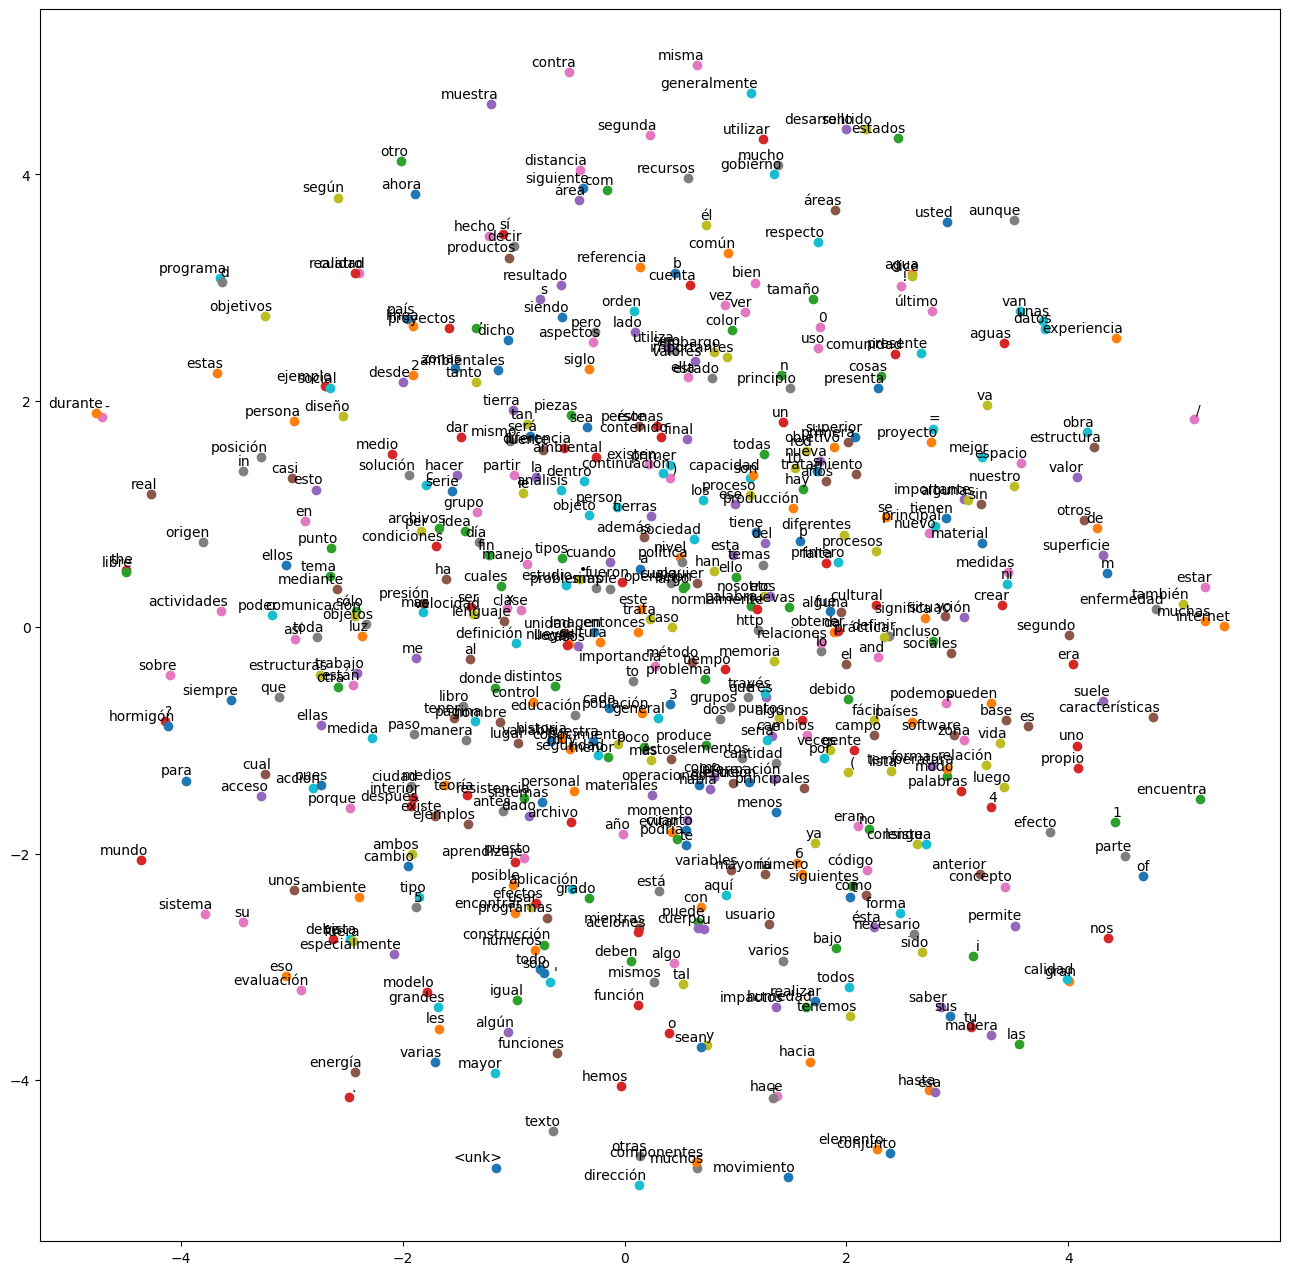

In [14]:
# visualize embeddings of the first 1000 words
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
embeddings = tsne.fit_transform(model.embedding.weight.detach().cpu().numpy()[:500, :])

plt.figure(figsize=(16, 16))
for i, label in enumerate(word_dataset.vocab.lookup_token(idx) for idx in range(500)):
    x, y = embeddings[i, :]

    if 
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.show()  
